## Introduction

On se lance dans le projet *N-body*. Il est conseillé d'utiliser C++, et c'est effectivement ce que nous allons faire. Néanmoins, pour des raisons pratiques, tous les plots seront faits en Python au travers de fichiers .txt.

Sans plus attendre, on va pouvoir se lancer dans les premières tâches du projet!

In [9]:
%matplotlib widget

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
import imageio
from fancy_package import *


plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12, 7)

import os
while not os.path.exists("files"):
    os.chdir("..")
print("Current directory:", os.getcwd())

Current directory: /home/kiwi/documents/zurich/compastro


___

## 1. First Task

On reste tranquillement en Python !

### 1.1. Première étape

* [X] Vérifier la forme de la fonction de densité $\rho(r)$. Comparer à la densité décrite dans le papier.
* [X] Check les choix d'unités, une fois que l'on a fixé G = 1.

La première étape est simplement de jeter un oeil au fichier `data.txt`. On commence par l'enregistrer dans un format plus pratique.

In [2]:
# let's save the file as a csv file that will be easier to read!
df = pd.read_csv("files/data.txt", sep="\s+", header=None, names=["index", "m", "x", "y", "z", "vx", "vy", "vz", "phi", "eps"]) # the .txt file is a nice format for c++, not for us!
df['r'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
df['vr'] = (df['x'] * df['vx'] + df['y'] * df['vy'] + df['z'] * df['vz']) / df['r']
df['v'] = np.sqrt(df['vx']**2 + df['vy']**2 + df['vz']**2)
df['v_theta'] = (df['x'] * df['vy'] - df['y'] * df['vx']) / df['r']
df.to_csv("files/data.csv", index=False) # save the file as a csv file
df = None

Jettons un oeil à ce dataframe !

In [3]:
particles_data = pd.read_csv("files/data.csv")
particles_data.head(3)

,index,m,x,y,z,vx,vy,vz,phi,eps,r,vr,v,v_theta
0,0,92.4259,-0.003816,-0.079670,-0.019072,3779.62,354.734,-73.45010,0.1,0.013022,0.082010,-503.423824,3796.940673,3655.273845
1,1,92.4259,-0.032298,-0.249461,-0.010890,3250.59,-674.280,-18.33470,0.1,0.013022,0.251779,251.883839,3319.838103,3307.162630
2,2,92.4259,0.067577,-0.810356,-0.006849,2190.86,199.053,3.86061,0.1,0.013022,0.813198,-16.328732,2199.887393,2199.745627


Dans (Hernquist et al.)[files/Hernquist_et_al.pdf], on trouve la densité de masse :
$$
\rho(r) = \frac{M}{2\pi} \frac{a}{r} \frac{1}{(r+a)^3}
$$
avec $M$ la masse totale et $a$ une échelle de distance charactéristique (qu'on va fit!). La distribution de masse cumulative (la masse entre $r$ et $r+dr$) est donc:

\begin{align*}
    M(R) &= \int_0^R 4 \pi r^2 \rho(r) dr \\
         &= 2M \int_0^R \frac{ar}{(r+a)^3} dr \\
         &= 2M \int_a^{a+R} \frac{a(u-a)}{u^3}du  \ \ \ (u = r + a) \\
         &= 2M \int_a^{a+R} \left( \frac{a}{u^2} - \frac{a^2}{u^3} \right) du\\
         &= 2M \left( \left[ -\frac{a}{u} \right]_a^{a+R} + \left[ \frac{a^2}{2u^2} \right]_a^{a+R} \right) \\
         &= 2M \left(
            1 - \frac{a}{a+R} + \frac{a^2}{2 (R+a)^2} - \frac{1}{2}
         \right)\\
         &= 2M \frac{1}{(R+a)^2} \left(
            \frac{1}{2}(R+a)^2 - a(R+a) + \frac{a^2}{2}
         \right)\\
         &= M \frac{R^2}{(R+a)^2}
\end{align*}

Voilà qui a une bonne tête ! Avec cette masse cumulative, on va pouvoir utiliser l'équivalent de la **loi de Gauss** pour un champ gravitationnel:
$$
\oint_{r=R} \vec{g} \cdot d\vec{S} = -4 \pi G M(R)
$$

Avec la symétrie centrale, on obtient:
$$
g_r 4 \pi R^2 = -4\pi \frac{GMR^2}{(R+a)^2} 
$$
et ainsi
$$
g_r = - \frac{GM}{(R+a)^2}
$$
qu'on intègre afin d'obtenir le potentiel gravitationnel:
$$
\phi(r) = \frac{GM}{(R+a)}
$$

Avec ces différentes équation, on peut se demander ce que représente $a$. Eh bien, par exemple, on avait:
$$
M(r) = M\frac{r^2}{(r+a)^2}
$$

Alors, $M(a) = M/4$. Toutefois, on peut s'intéresser à une distance caractéristique plus naturelle $$ M(R_{1/2}) = M/2 $$ ou une fois l'équation résolue :
$$
R_{1/2} = (1 + \sqrt{2})a
$$

Cette distance caractéristique va nous permettre de définir le *crossing time*: 
$$
t_{cross} = \frac{R_{1/2}}{v_{cross}} =  \sqrt{\frac{R_{1/2}^3}{G M_{1/2}}}
$$
i.e.
$$
t_{cross} =  \sqrt{\frac{2 \left((1 + \sqrt{2})a\right)^3}{G M}}
$$

On en déduit également le *relaxation time*:
$$
t_{rel} = \frac{N}{8 \log( \Lambda)} t_{cross}
$$
avec
$$
\Lambda = \frac{b_{max}}{b_{min}}
$$

Ici, $b_{max}$ est la distance caractéristique maximale qu'on souhaite considérer. Dans notre cas, c'est $b_{max} \approx R_{1/2}$. D'un autre côté, $b_{min}$ correspond à l'échelle interparticulaire minimale. Pour une densité uniforme, elle correspond à $b_{min} = \frac{R}{N^{1/3}}$ et on retrouve $\Lambda \propto \log(N)$. On pourra utiliser $R_{1/2}$. Toutefois, dans le cas présent, au centre la densité de particules est infinie, donc c'est bof bof. La grandeur intéressante est dès lors $\epsilon$, ce qui répond à une des questions posées par le prof.

Bref, tout ça ce sont des grandeurs intéressantes qu'il adviendra de calculer. Mais trêve de blabla, jettons un peu un oeil à nos données !

Parameter a: 0.0804


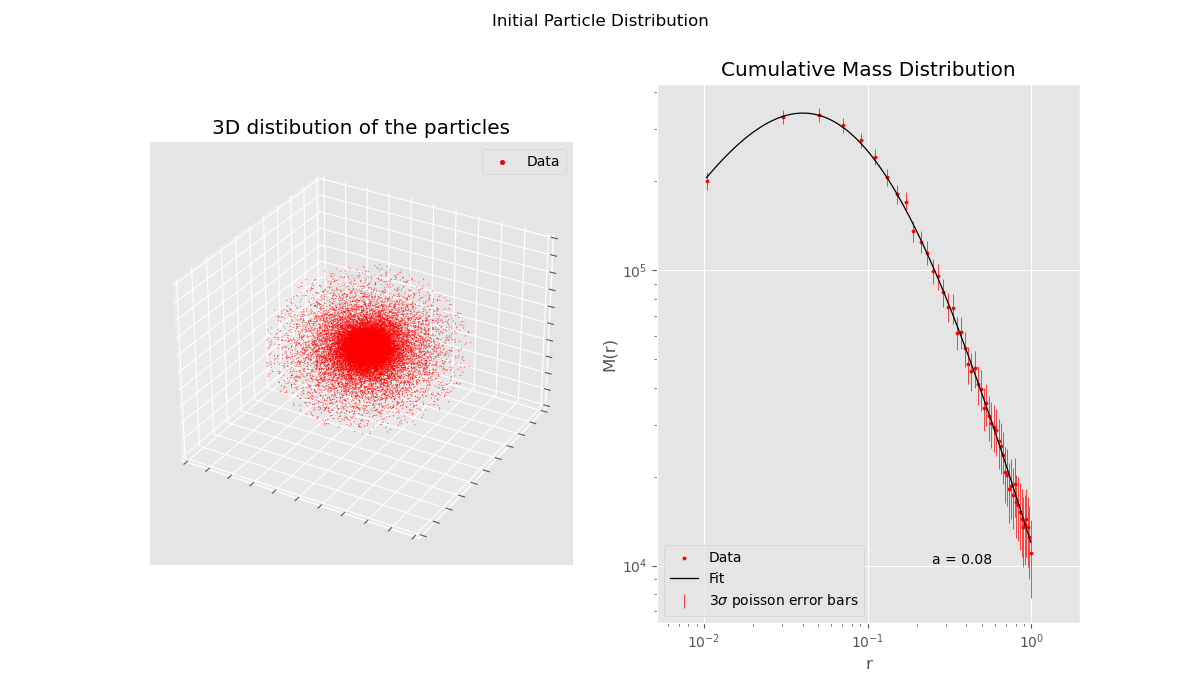

In [10]:
NBINS = 50

df_to_plot = particles_data[particles_data["r"]<1]

#3d scatter of the data
plt.figure()
plt.suptitle("Initial Particle Distribution")
grid = GridSpec(1, 2, hspace=1)
plt.subplot(grid[0], projection="3d")
plt.title("3D distibution of the particles")
plt.gca().scatter(df_to_plot["x"], df_to_plot["y"], df_to_plot["z"], color='red', s=0.1)
plt.gca().scatter([],[],[], label="Data", color='red', s=10)
plt.legend()
plt.xticks(plt.xticks()[0], [])
plt.yticks(plt.yticks()[0], [])
plt.gca().set_zticks(plt.gca().get_zticks(), [])

plt.subplot(grid[1])

# we need this data if we want to do a fit
hist, bin_edges = np.histogram(df_to_plot["r"], bins=NBINS, weights=df_to_plot["m"])
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2


M = particles_data["m"].sum()
def rho(r, a):
    rho_r = M / (2*np.pi) * (a/r) * 1/((r+a)**3)
    return rho_r * 4*np.pi*r**2 * 1/NBINS

x = np.linspace(min(bin_centers), max(bin_centers), 1000)
a, _ = curve_fit(rho, bin_centers, hist)
a = a[0]
print(f"Parameter a: {a:.4f}")

# count the number of particles in each bin

plt.title("Cumulative Mass Distribution")


plt.scatter(bin_centers, hist, color='red', s=5, label="Data")

errors = np.sqrt(hist / (M/len(df_to_plot))) * M/len(df_to_plot) * 3 # sigma = sqrt(N)
plt.errorbar(bin_centers, hist, yerr=errors, fmt='none', color='red', elinewidth=0.5, label = "$3\sigma$ poisson error bars") # we don't see a thing...

plt.plot(x, rho(x, a), label="Fit", color='black', linewidth=0.9)
#errors = np.sqrt(rho(x, a))*5
#plt.fill_between(x, rho(x, a)-errors, rho(x, a)+errors, alpha=0.3, color='black')
plt.text(0.65, 0.11, f"a = {a:.2f}", transform=plt.gca().transAxes)

plt.xlabel("r")
plt.ylabel("M(r)")
plt.xlim(np.min(x)/2, np.max(x)*2)

plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.show()

On peut maintenant s'intéresser à la distribution de vitesse. Notamment, en fonction de la distance au centre, sa norme et sa composante radiale (la composante orthoradiale est alors donnée par la formule de Pythagore). On pourra aussi regarder la valeur moyenne de la vitesse et la comparer au crossing time.

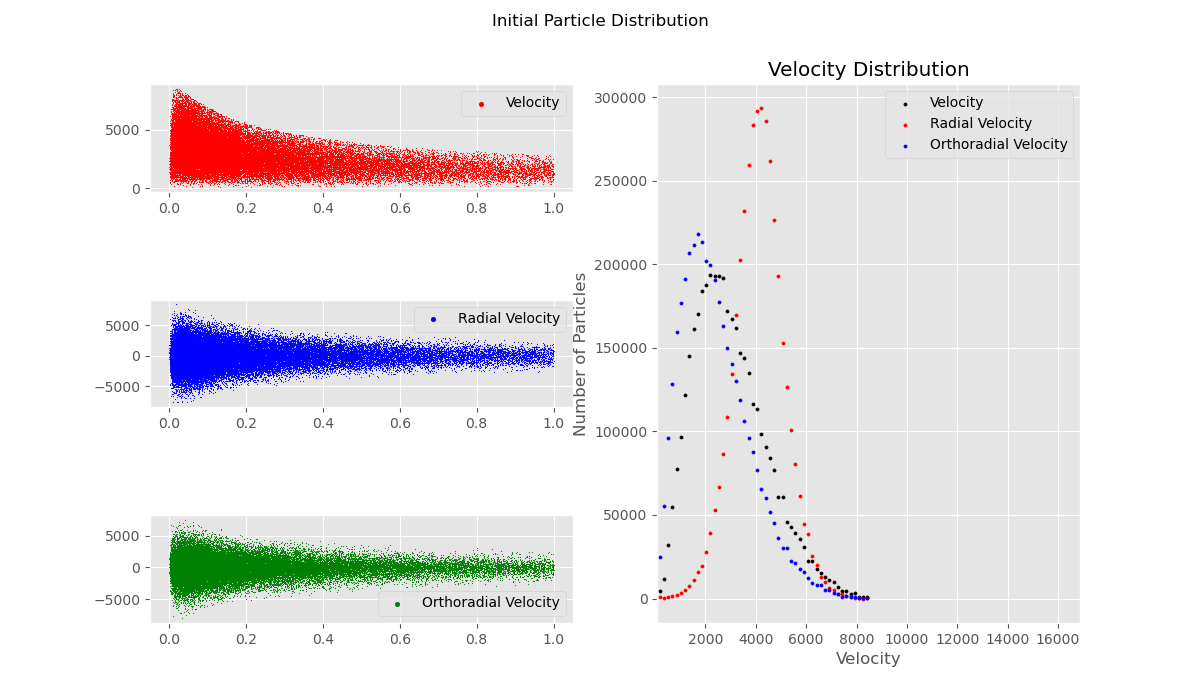

In [11]:
NBINS = 50

df_to_plot = particles_data[particles_data["r"]<1]

#3d scatter of the data
plt.figure()
plt.suptitle("Initial Particle Distribution")
grid = GridSpec(3, 2, hspace=1)

plt.subplot(grid[0, 0])
plt.scatter(df_to_plot["r"], df_to_plot["v"], color='red', s=0.1)
plt.scatter([],[], label="Velocity", color='red', s=10)
plt.legend()

plt.subplot(grid[1, 0])
plt.scatter(df_to_plot["r"], df_to_plot["vr"], color='blue', s=0.1)
plt.scatter([],[], label="Radial Velocity", color='blue', s=10)
plt.legend()

plt.subplot(grid[2, 0])
plt.scatter(df_to_plot["r"], df_to_plot["v_theta"], color='green', s=0.1)
plt.scatter([],[], label="Orthoradial Velocity", color='green', s=10)
plt.legend()


plt.subplot(grid[:,1])

# we need this data if we want to do a fit
hist, bin_edges = np.histogram(df_to_plot["v"], bins=NBINS, weights=df_to_plot["m"])
hist_radial, bin_edges_radial = np.histogram(df_to_plot["vr"], bins=NBINS, weights=df_to_plot["m"])
hist_orthoradial, bin_edges_orthoradial = np.histogram(np.sqrt(df_to_plot["v"]**2 - df_to_plot["vr"]**2), bins=NBINS, weights=df_to_plot["m"])
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
x = np.linspace(min(bin_centers), max(bin_centers), 1000)



# count the number of particles in each bin

plt.title("Velocity Distribution")

plt.scatter(bin_centers, hist, color='black', s=5, label="Velocity")
plt.scatter(bin_centers, hist_radial, color='red', s=5, label="Radial Velocity")
plt.scatter(bin_centers, hist_orthoradial, color='blue', s=5, label="Orthoradial Velocity")

plt.xlabel("Velocity")
plt.ylabel("Number of Particles")
plt.xlim(np.min(x)/2, np.max(x)*2)

#plt.xscale("log")
#plt.yscale("log")

plt.legend()
plt.show()

In [6]:
print(f"Average particle velocity: {particles_data['v'].median():.0f}")

Average particle velocity: 2483


Je soupçonne qu'on a introduit une température, et donc une distribution gaussienne de la velocité, sans lien avec la distance à l'origine.

Voilà qui est fait ! Maintenant, parlons un peu des unités. En gros, si on veut simuler des galaxies, les grandeurs de masse et de distance sont à peu près fixées:

\begin{align*}
M_{tot} &= 10^{10} M_{\odot}\\
R &= 40 kpc
\end{align*}

Là on ne se pose pas vraiment de question. L'inconnue c'est plutôt le pas de temps. En effet, si on utilise $G \approx 10^{-11}$, on va devoir attendre des milliards d'années pour voir la galaxie évoluer. On décide plutôt de fixer $G=1$. La dimension du temps sera alors bien plus raisonnable, ce qu'on constate après une simple analyse dimensionnelle. On se rappelle de la formule de la *typical particle velocity*:

$$
v = \sqrt{\frac{GM_{tot}}{R}}
$$

Le temps caractéristique de collision de deux particules était alors $t_{cross} = \frac{R}{v} = \frac{R^{3/2}}{\sqrt{GM_{tot}}}$ (pour rappel, le temps de relaxation est proportionnel à $t_{cross}$ et au nombre de particules). En fixant G=1, on choisit d'exprimer le temps caractéristique :

$$
t_{cross} = \sqrt{\frac{R^3}{M_{tot}}}
$$

Mais bon en vrai je comprends pas trop ce qu'on est censé dire à partir de là... Néamoins on va calculer $t_{cross}$ et compagnie.

In [9]:
G = 1
M_tot = particles_data["m"].sum()
N = len(particles_data)
m = M_tot / N
R_half = (1 + np.sqrt(2)) * a

t_cross = np.sqrt(
    R_half**3 / (G * M_tot)
)

b_max = R_half
b_min = R_half / (N/2)**(1/3)

t_relax = N / (8 * np.log(b_max / b_min)) * t_cross

print(f"Total Mass: {M_tot:.2e}")
print(f"Half Mass Radius: {R_half:.2f}")
print(f"Characteristic velocity: {np.sqrt(M_tot / R_half):.0f}")
print(f"Crossing time: {t_cross:.2e}")
print(f"Relaxation time: {t_relax:.2e}")

Total Mass: 4.62e+06
Half Mass Radius: 0.19
Characteristic velocity: 4880
Crossing time: 3.98e-05
Relaxation time: 7.37e-02


Quelles sont les unités ici? Commençons par quelques valeurs pour la voie lactée :
- $\rm R_{1/2} = 3 kpc$ d'après [cet article](https://iopscience.iop.org/article/10.3847/2041-8213/ac76c8/meta)
- $\rm M_{tot} = 10^{12} M_\odot$

Les grandeurs données dans le fichier `.txt` sont certainement celles d'un amas globulaires (d'étoiles ?). Mais si nous on décide de les appliquer à une galaxie, il faut faire matcher les unités. Déterminons les unités de masse, de distance, et surtout de temps (qui sera fixé par G=1).

Il est toutefois important de noter qu'une galaxie n'est oas très adaptée aux données initiales. Notamment parce qu'une galaxie est aplatie, alors qu'un **amas globulaire** est plus plat. Les unités sont alors particulièrement cohérentes : l'unité de masse est $M_\odot$.

In [11]:
milky_way = {
    "half_mass_radius": 3, # kpc
    "total_mass": 10**12, # solar masses
}

radius_unit = milky_way["half_mass_radius"] / R_half
mass_unit = milky_way["total_mass"] / M_tot

print(f"Radius unit: {radius_unit:.1f} kpc")
print(f"Mass unit: {mass_unit:.1f} M_sun")

Radius unit: 15.5 kpc
Mass unit: 216346.3 M_sun


Or, on peut exprimer G en ces unités :
$$\rm
G = 4.302 \times 10^{-3} kpc^3 M_{\odot}^{-1}Gyr^{-2}
$$
et en déduire l'unité de temps :
$$
[T] = \sqrt{\frac{[L^3]}{[M][G]}}
$$

Toutefois, on voudrait avoir $G=1$. Pour cela, on va changer notre unité de temps. En fait, on va poser G=1 dans nos calculs, on va en déduire le crossing time, et puis on va convertir le crossing time pour obtenir la bonne valeur.

In [12]:
G_unit = 4.302e-3 # kcp^3 / (M_sun * Gyr^2)
t_cross_kpcm_odotmyr = np.sqrt(
    (milky_way["half_mass_radius"])**3 / (G_unit * milky_way["total_mass"])
)
print(f"Crossing time: {t_cross_kpcm_odotmyr:.2e} Gyr")
print(f"Crossing time: {t_cross:.2e} SimUnits")

Crossing time: 7.92e-05 Gyr
Crossing time: 3.98e-05 SimUnits


### 1.2. Deuxième Étape

* [ ] Calculer les forces appliquées à chaque particule de manière directe (avec $\epsilon$). Tester pour différentes valeurs de $\epsilon$.
* [ ] Comparer des calculs directs de forces à la solution exacte donnée par le livre *Galactic Dynamics* (aussi appelée **loi de Gauss** cf ci-dessus, on a déjà la valeur de la Force).
* [ ] Calculer le temps de relaxation du system et commenter le lien avec $\epsilon$.

Pour ça, on va avoir besoin d'un calcul direct des forces. Le script en Python part pour 44h (à cause de `iterrows` je crois, en vrai ça doit pas être si long que ça), donc ça ne va pas le faire. On va préférer créer un programme en C++ qui exportera le résultat dans un fichier.

Commençons par tester la méthode de calcul direct combinée avec la méthode d'Euler. On peut tester ça tout d'abord sur un problème à trois corps stable.

Dataframe loaded for 3 body direct summation of shape:  (15003, 10)


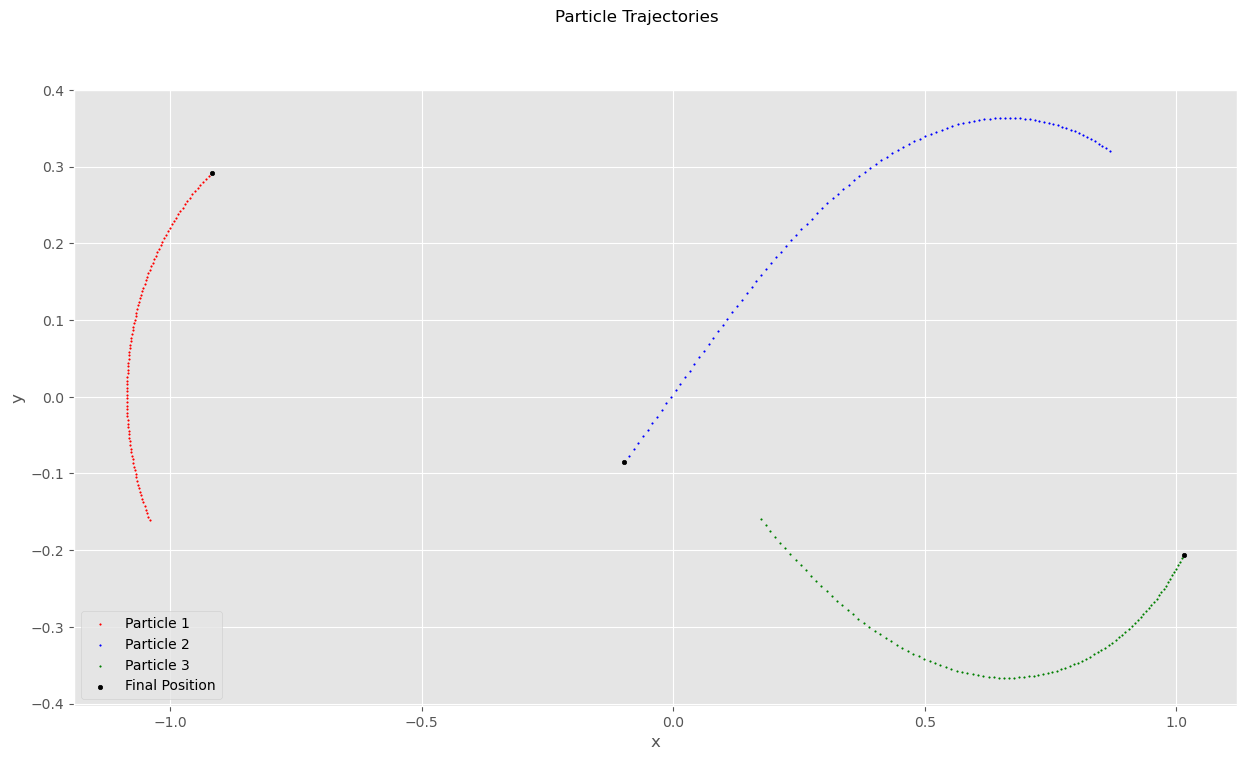

In [14]:
particles_3body = pd.read_csv("files/tests/DIRECT_EULER_N=3_stable.csv")
print("Dataframe loaded for 3 body direct summation of shape: ", particles_3body.shape)
start_time = 1000
n_traj  = 100 # we draw this number of points for each one of our 3 particles

# let's make the plot!
start_time = start_time - start_time%3

df_frame = particles_3body.iloc[start_time:start_time+3*n_traj]
df1 = df_frame.iloc[::3]
df2 = df_frame.iloc[1::3]
df3 = df_frame.iloc[2::3]

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Particle Trajectories")
plt.scatter(df1["x"], df1["y"], color='red', s=1, label="Particle 1")
plt.scatter(df2["x"], df2["y"], color='blue', s=1, label="Particle 2")
plt.scatter(df3["x"], df3["y"], color='green', s=1, label="Particle 3")
plt.scatter([df1["x"].iloc[-1], df2["x"].iloc[-1], df3["x"].iloc[-1]], [df1["y"].iloc[-1], df2["y"].iloc[-1], df3["y"].iloc[-1]], color='black', s=10, label="Final Position")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Ca a l'air de bien marcher ! Maintenant, on peut tester le calcul directe des forces sur les particules fournies par le prof. Il va falloir s'accrocher un peu parce qu'on a beaucoup de choses à calculer.

```python
# TODO: try direct calculation for different epsilon's
```

On commence par comparer la force théorique à la force calculée par la sommation directe.

In [15]:
direct_force_data = pd.read_csv("files/output/DIRECT_FORCES_eps=0.000000_data.csv")
df = pd.concat([ # df will contain everything: force from direct, tree and quadtree
    particles_data[["m", "x", "y", "z", "r", "vx", "vy", "vz", "phi", "eps"]],
    direct_force_data[["fx", "fy", "fz"]].rename(columns={"fx": "fx_direct", "fy": "fy_direct", "fz": "fz_direct"}),
], axis = 1)

df["fr_direct"] = (df["x"] * df["fx_direct"] + df["y"] * df["fy_direct"] + df["z"] * df["fz_direct"]) / df["r"]

La question maitenant, c'est que faire de ça ? Que souhaite-t-on comparer, calculer ? Eh bien on va comparer les différentes réalisations de $F_r(r)$ à la valuer théorique de $F_r^{th}(r)$. On fait ça avec un scatter plot.

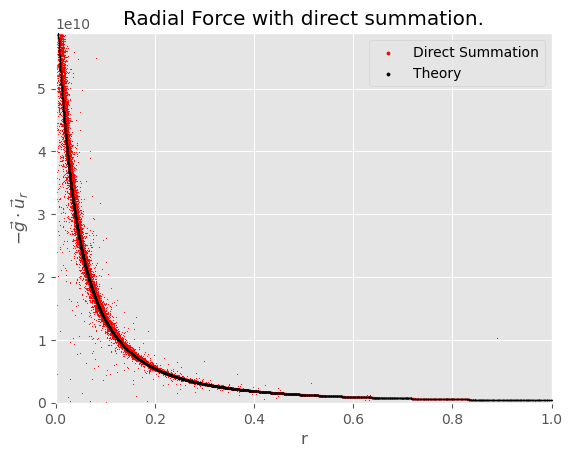

In [16]:
M = df["m"].sum()
m = df["m"].mean() # it is actually the same mass for al of them

plt.scatter(df["r"], -df["fr_direct"], s=0.1, color="red")
plt.scatter([], [], label=r"Direct Summation", color="red", s=5)

# theoretical curve
def f(r, a=0.08):
    return -M*m / (r+a)**2

df["fr_theory"] = f(df["r"])

r = np.linspace(0, 1)
plt.scatter(df["r"], -df["fr_theory"], s=0.1, color="black", zorder=10)
plt.scatter([], [], label="Theory", color="black", s=5)

plt.xlim(0, 1)
plt.ylim(0, -df["fr_direct"].quantile(0.01))
plt.title("Radial Force with direct summation.")
plt.legend()
plt.xlabel("r")
plt.ylabel(r"$-\vec{g} \cdot \vec{u}_r$")
plt.show()

On constate qu'il y a quelques points qui, même à très faible rayon, sont négatif, i.e. sont tirés dans le mauvais sens. Probablement ont-ils juste au dessus d'eux un autre point qui les attire beaucoup. Augmenter $\epsilon$ devrait diminuer cet effet, homogénéiser les forces, faire une moyenne sur nos petits points.

Ca on se permet de le garder pour plus tard. Il est également intéressant de se demander dans quelle mesure la courbe calculée par sommation directe est proche de la courbe théorique.

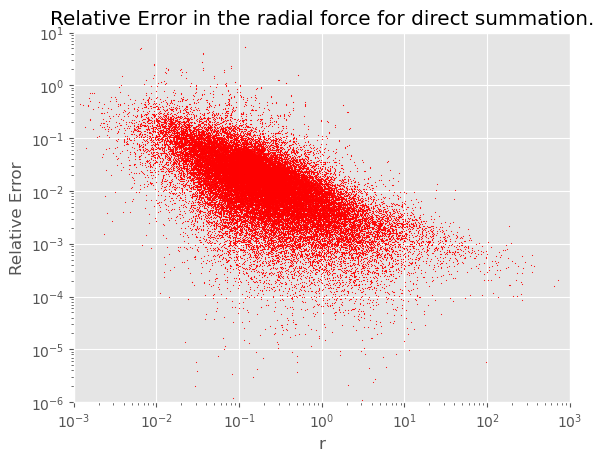

In [17]:
relative_error = np.abs(df["fr_direct"] - df["fr_theory"]) / np.abs(df["fr_theory"])
plt.scatter(df["r"], relative_error, s=0.1, color="red")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-3, 1e3)
plt.ylim(1e-6, 10)
plt.xlabel("r")
plt.ylabel("Relative Error")
plt.title("Relative Error in the radial force for direct summation.")
plt.show()

Une fois de plus:
```python
#TODO : do this for different softenings
```

___

## 2. Second Task: tree-code

### 2.1. Force Calculations
* [X] code the multipole expansion
* [X] create the tree
* [X] decide on a distance based criterion
* [X] compute force, compare with the correct result, and compare computationnal cost.
* [X] compare result with direct summation, try different opening angles and different softening

Cf les autres Notebooks pour les calculs (faux).

Le code a été vérifié, moi j'y crois, donc on applique nos algorithmes aux données !

In [19]:
monopole_force_data = pd.read_csv("files/output/TREE-MONO_FORCES_data.csv")
df["fx_mono"], df["fy_mono"], df["fz_mono"] = monopole_force_data["fx"], monopole_force_data["fy"], monopole_force_data["fz"]
df["fr_mono"] = (df["x"] * df["fx_mono"] + df["y"] * df["fy_mono"] + df["z"] * df["fz_mono"]) / df["r"]

quadru_force_data = pd.read_csv("files/output/TREE-QUAD_FORCES_data.csv")
df["fx_quad"], df["fy_quad"], df["fz_quad"] = quadru_force_data["fx"], quadru_force_data["fy"], quadru_force_data["fz"]
df["fr_quad"] = (df["x"] * df["fx_quad"] + df["y"] * df["fy_quad"] + df["z"] * df["fz_quad"]) / df["r"]

Bon, tout est prêt, on peut regarder ce que ça donne. Cette fois on ne veut pas vraiment comparer à la courbe théorique, mais plutôt à la direct summation. Mais bon en même temps la courbe théorique elle permet d'y voir quelque chose, donc on va aussi l'utiliser.

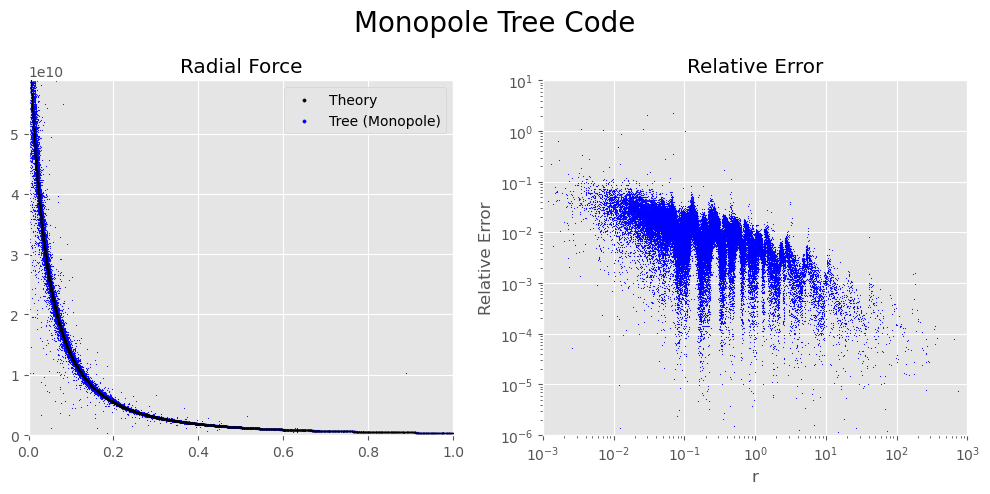

In [20]:
M = df["m"].sum()
m = df["m"].mean()

plt.figure(figsize=(10, 5))
plt.suptitle("Monopole Tree Code", fontsize=20)
plt.subplot(1, 2, 1)
plt.title("Radial Force")
plt.scatter(df["r"], -df["fr_theory"], s=0.1, color="black", zorder=10)
plt.scatter([], [], label=r"Theory", color="black", s=5)
plt.scatter(df["r"], -df["fr_mono"], s=0.1, color="blue")
plt.scatter([], [], label=r"Tree (Monopole)", color="blue", s=5)
plt.xlim(0, 1)
plt.ylim(0, -df["fr_direct"].quantile(0.01))
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Relative Error")
plt.scatter(df["r"], np.abs(df["fr_mono"] - df["fr_direct"]) / np.abs(df["fr_direct"]), s=0.1, color="blue")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-3, 1e3)
plt.ylim(1e-6, 10)
plt.xlabel("r")
plt.ylabel("Relative Error")
plt.tight_layout()
plt.show()


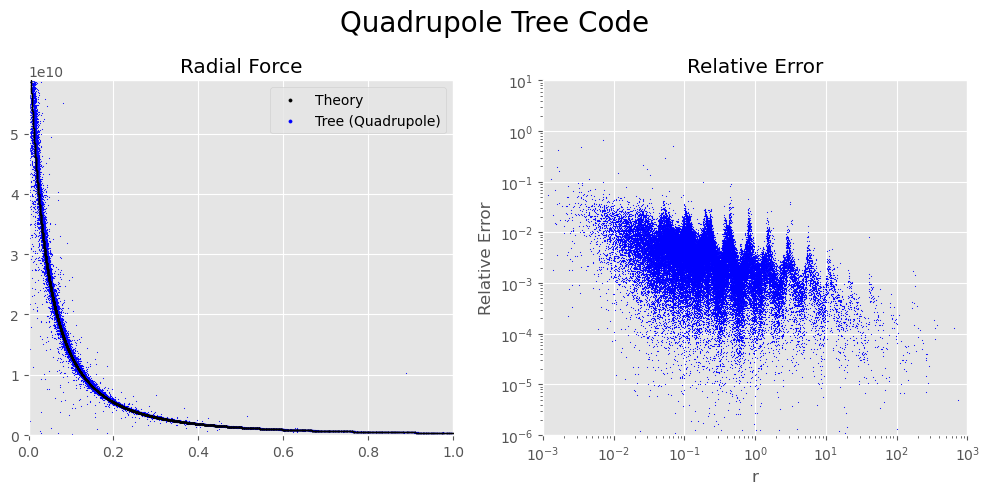

In [21]:
M = df["m"].sum()
m = df["m"].mean()

plt.figure(figsize=(10, 5))
plt.suptitle("Quadrupole Tree Code", fontsize=20)
plt.subplot(1, 2, 1)
plt.title("Radial Force")
plt.scatter(df["r"], -df["fr_theory"], s=0.1, color="black", zorder=10)
plt.scatter([], [], label=r"Theory", color="black", s=5)
plt.scatter(df["r"], -df["fr_quad"], s=0.1, color="blue")
plt.scatter([], [], label=r"Tree (Quadrupole)", color="blue", s=5)
plt.xlim(0, 1)
plt.ylim(0, -df["fr_direct"].quantile(0.01))
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Relative Error")
plt.scatter(df["r"], np.abs(df["fr_quad"] - df["fr_direct"]) / np.abs(df["fr_direct"]), s=0.1, color="blue")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-3, 1e3)
plt.ylim(1e-6, 10)
plt.xlabel("r")
plt.ylabel("Relative Error")
plt.tight_layout()
plt.show()

In [22]:
print("Average relative error (monopole):", f'{(np.abs(df["fr_mono"] - df["fr_direct"]) / np.abs(df["fr_direct"])).mean():.3%}')
print("Average relative error (quadrupole):", f'{(np.abs(df["fr_quad"] - df["fr_direct"]) / np.abs(df["fr_direct"])).mean():.3%}')
print("Average relative difference between both:", f'{(np.abs(df["fr_quad"] - df["fr_mono"]) / np.abs(df["fr_direct"])).mean():.3%}')

Average relative error (monopole): 1.091%
Average relative error (quadrupole): 0.411%
Average relative difference between both: 1.006%


Et voilà! En plus, le quadrupole a effectivement de meilleurs performances que le monopole. Et niveau temps, voici ce que l'on obtient :
- calcul direct: 22s
- monopole: 0.8s
- quadrupole: 2s

C'est quand même une chouette amélioration, et si on augmente le nombre de particules, ça sera de mieux en mieux ! Après l'introduction du quadrupole, comparé à une réduction de l'angle d'ouveture, est questionnalbe.

```python
# TODO: tester changer opening angle vs quadrupole
# TODO: tester time dependance
```

In [23]:
mono_evol = pd.read_csv("files/output/evolve_monopole/mono_100-iter.csv").rename(columns={"phi": "t"})

plots_folder = "files/output/evolve_monopole/animation"

if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)

for i,t in ProgressBar(list(enumerate(sorted(mono_evol["t"].unique())))):
    particles = mono_evol[mono_evol["t"] == t]
    plt.figure(figsize=(10, 10), dpi=200)
    plt.scatter(particles["x"], particles["y"], s=1)
    
    # convert t into million years
    t *= t_cross_kpcm_odotmyr / t_cross
    plt.title(f"t = {t:.2e} Gyr")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.savefig(os.path.join(plots_folder, f"mono_{i}.png"))
    plt.close()

[%]  Done!                                                  


In [28]:
# let's make the gif

# Get a sorted list of all PNG files in the folder
png_files = sorted([f for f in os.listdir(plots_folder) if f.endswith(".png")], key=lambda x: (len(x), x))

# Create the output path for the GIF
gif_path = os.path.join(plots_folder, "animation.gif")

# Create a GIF from the PNG files
with imageio.get_writer(gif_path, mode='I', duration=0.1, loop=0) as writer:  # Adjust duration (in seconds) per frame as needed
    for png in ProgressBar(png_files):
        image_path = os.path.join(plots_folder, png)
        writer.append_data(imageio.imread(image_path))

print(f"GIF created successfully at {gif_path}")

/tmp/ipykernel_1590/2348972740.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(image_path))


[%]  Done!                                                  
GIF created successfully at files/output/evolve_monopole/animation/animation.gif
